(10000, 1)
(10000, 1)
(10000, 1)


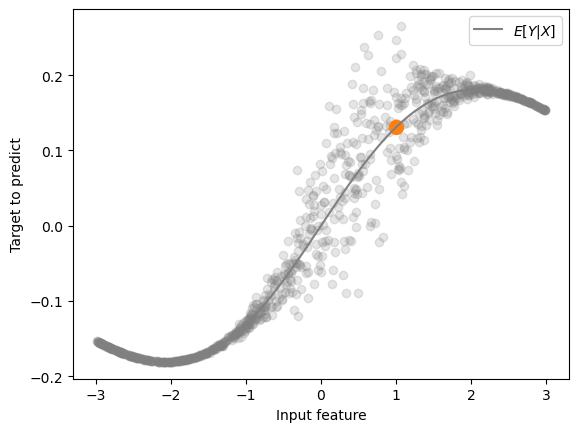

In [1]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import norm


rng = np.random.default_rng(0)
n_samples = int(3e4)
x = rng.uniform(low=-3, high=3, size=n_samples)
X = x.reshape((n_samples, 1))


def true_y_mean(x):
    return expit(x) - 0.5 - 0.1 * x


def true_y_std(x):
    return 0.07 * np.exp(-((x - 0.5) ** 2) / 0.9)


y = rng.normal(loc=true_y_mean(x), scale=true_y_std(x))

X_train, X_out, x_train, x_out, y_train, y_out = train_test_split(
    X, x, y, test_size=2 / 3, random_state=0
)
X_cal, X_test, x_cal, x_test, y_cal, y_test = train_test_split(
    X_out, x_out, y_out, test_size=1 / 2, random_state=0
)
print(X_train.shape)
print(X_cal.shape)
print(X_test.shape)


def plot_data_generating_process(
    x,
    y,
    plot_data=True,
    max_scatter_points=1_000,
    plot_mean=True,
    plot_005_quantile=True,
    plot_095_quantile=True,
    color="gray",
    highlight_indices=None,
    ax=None,
):
    x_grid = np.linspace(x.min(), x.max(), 100)
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)
    if plot_data:
        ax.scatter(
            x=x[:max_scatter_points],
            y=y[:max_scatter_points],
            alpha=0.2,
            color=color,
        )

    if plot_mean:
        ax.plot(x_grid, true_y_mean(x_grid), label="$E[Y|X]$", color=color)
    if plot_095_quantile:
        ax.plot(
            x_grid,
            true_y_mean(x_grid) + norm.ppf(0.95) * true_y_std(x_grid),
            linestyle="--",
            color=color,
        )
    if plot_005_quantile:
        ax.plot(
            x_grid,
            true_y_mean(x_grid) - norm.ppf(0.95) * true_y_std(x_grid),
            linestyle="--",
            label=r"$Q[Y|X]$",
            color=color,
        )
    if plot_data and highlight_indices:
        for i, idx in enumerate(highlight_indices):
            ax.scatter(
                x=[x[idx]], y=[y[idx]], alpha=1, marker="^", s=100, color=f"C{i}"
            )
    if plot_mean or plot_005_quantile:
        ax.legend()


fig, ax = plt.subplots()
ax.set(xlabel="Input feature", ylabel="Target to predict")
plot_data_generating_process(
    x_train, y_train, ax=ax, plot_005_quantile=False, plot_095_quantile=False
)
ax.scatter(x=[1], y=[true_y_mean(1)], color="C1", marker="o", s=100)


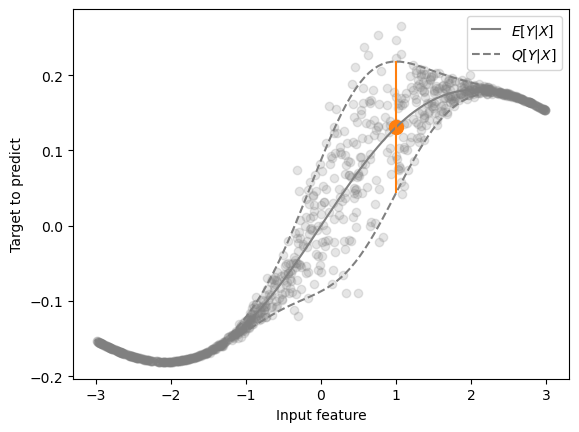

In [2]:
fig, ax = plt.subplots()
ax.set(xlabel="Input feature", ylabel="Target to predict")
plot_data_generating_process(
    x_train, y_train, ax=ax, plot_005_quantile=True, plot_095_quantile=True
)
ax.scatter(x=[1], y=[true_y_mean(1)], color="C1", marker="o", s=100)
ax.vlines(
    x=1,
    ymin=true_y_mean(1) - norm.ppf(0.95) * true_y_std(1),
    ymax=true_y_mean(1) + norm.ppf(0.95) * true_y_std(1),
    color="C1",
    linestyle="-",
)

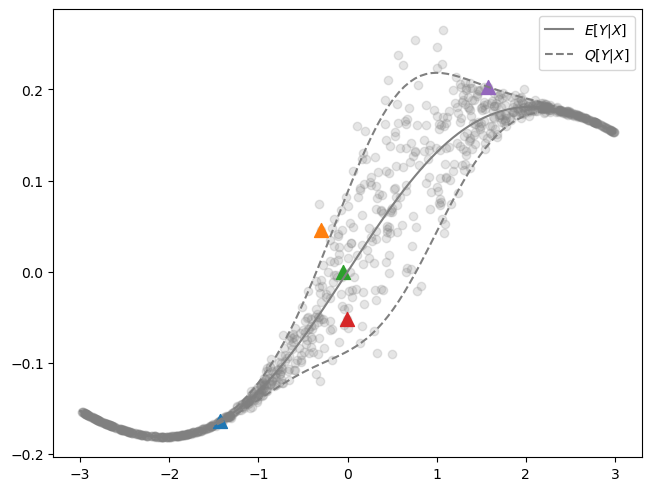

In [3]:
import pandas as pd

df_train = pd.DataFrame(
    {"x": x_train, "y": y_train, "y_diff": y_train - true_y_mean(x_train)}
)[:1000]
df_train["x_bin"] = pd.qcut(df_train["x"], q=5, labels=range(5))
highlight_indices = []

for x_bin in [1, 2, 3]:
    region = df_train.query("x_bin == @x_bin", engine='python').copy()
    region["y_diff_bin"] = pd.qcut(region["y_diff"], q=20, labels=range(20))
    if x_bin in [1, 3]:
        trimmed_region = region.query(
            "y_diff_bin > 0 & y_diff_bin < 18", engine="python"
        )
        highlight_indices.extend(trimmed_region.sample(n=1, random_state=0).index)
    if x_bin == 2:
        highlight_indices.extend(
            region.query("y_diff_bin == 1", engine="python")
            .sample(n=1, random_state=0)
            .index
        )
        highlight_indices.extend(
            region.query("y_diff_bin == 10", engine="python")
            .sample(n=1, random_state=0)
            .index
        )
        highlight_indices.extend(
            region.query("y_diff_bin == 18", engine="python")
            .sample(n=1, random_state=0)
            .index
        )

highlight_indices = df_train.iloc[highlight_indices].sort_values(by="x").index.tolist()
plot_data_generating_process(x_train, y_train, highlight_indices=highlight_indices)

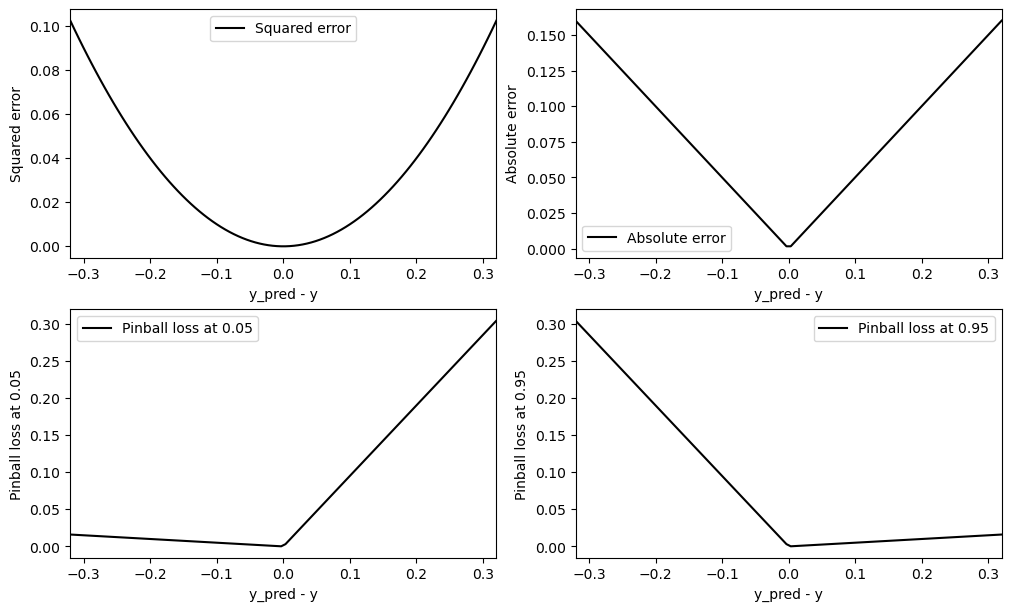

In [4]:
from sklearn.metrics import mean_squared_error, mean_pinball_loss
from functools import partial


def make_loss_function(loss_name, quantile=0.5, return_label=True):
    if loss_name == "squared_error":
        if return_label:
            return mean_squared_error, "MSE loss"
        else:
            return mean_squared_error
    elif loss_name == "quantile":
        if return_label:
            return (
                partial(mean_pinball_loss, alpha=quantile),
                f"Pinball loss (q={quantile:.2f})",
            )
        else:
            return partial(mean_pinball_loss, alpha=quantile)
    else:
        raise ValueError(f"Unsupported loss {loss_name:!r}")


def plot_loss_function(
    loss_fun,
    loss_label,
    y_true,
    y_pred,
    highlight_indices=None,
    diff_grid_range=None,
    data_name="train",
    mean_loss=True,
    legend=True,
    ax=None,
):
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)

    if diff_grid_range is None:
        # Maximum absolute diff observed for a 0 prediction (e.g. a linear
        # model init).
        max_abs = np.abs(y_true).max()
        diff_grid_range = (-max_abs, max_abs)

    if mean_loss:
        mean_loss_value = loss_fun(y_true, y_pred)
        ax.hlines(
            mean_loss_value,
            diff_grid_range[0],
            diff_grid_range[1],
            label=f"Mean loss value ({data_name} set): {mean_loss_value:.3f}",
            linestyle="--",
            color="black",
        )
    n_steps = 100
    y_pred_grid = np.linspace(diff_grid_range[0], diff_grid_range[1], n_steps)
    ax.plot(
        y_pred_grid,
        [loss_fun([0], [y_pred_grid_i]) for y_pred_grid_i in y_pred_grid],
        color="black",
        label=loss_label,
    )
    if highlight_indices:
        for i, idx in enumerate(highlight_indices):
            loss_value = loss_fun([y_true[idx]], [y_pred[idx]])
            ax.scatter(
                y_pred[idx] - y_true[idx],
                loss_value,
                color=f"C{i}",
                s=100,
                marker="^",
            )
    ax.set(xlim=diff_grid_range, xlabel="y_pred - y", ylabel=loss_label)
    if legend:
        ax.legend()


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), constrained_layout=True)

plot_loss_function(
    mean_squared_error,
    "Squared error",
    y_train,
    true_y_mean(x_train),
    mean_loss=False,
    # highlight_indices=highlight_indices,
    ax=axs[0, 0],
)
plot_loss_function(
    partial(mean_pinball_loss, alpha=0.5),
    "Absolute error",
    y_train,
    true_y_mean(x_train),
    # highlight_indices=highlight_indices,
    mean_loss=False,
    ax=axs[0, 1],
)
quantile_up = 0.95
plot_loss_function(
    partial(mean_pinball_loss, alpha=(1 - quantile_up)),
    f"Pinball loss at {1 - quantile_up:.2f}",
    y_train,
    true_y_mean(x_train) - norm.ppf(quantile_up) * true_y_std(x_train),
    # highlight_indices=highlight_indices,
    mean_loss=False,
    ax=axs[1, 0],
)
plot_loss_function(
    partial(mean_pinball_loss, alpha=quantile_up),
    f"Pinball loss at {quantile_up:.2f}",
    y_train,
    true_y_mean(x_train) + norm.ppf(quantile_up) * true_y_std(x_train),
    # highlight_indices=highlight_indices,
    mean_loss=False,
    ax=axs[1, 1],
)

In [5]:
def reliability_diagram(y_and_y_pred, n_bins=11, quantile_level=None, show_ideal=True, ax=None):
    load_min = y_and_y_pred["y"].min()
    load_max = y_and_y_pred["y"].max()
    load_range = [load_min, load_max]

    if ax is None:
        _, ax = plt.subplots()

    if show_ideal:
        ax.plot(load_range, load_range, linestyle="--", color="black", label="Ideal")

    y_and_y_pred["prediction_bin"] = pd.qcut(
        y_and_y_pred["y_pred"],
        q=n_bins,
    )
    if quantile_level is None:
        agg_func = "mean"
        label = "Conditional mean"
    else:
        agg_func = partial(np.quantile, q=quantile_level)
        label = f"Conditional {int(quantile_level * 100)}%-percentile"

    aggregated_per_bin = y_and_y_pred.groupby("prediction_bin", observed=True).agg(
        y=("y", agg_func),
        y_pred=("y_pred", "mean"),
    )
    aggregated_per_bin.plot(x="y_pred", y="y", marker="o", ax=ax, label=label)
    ax.set(
        xlim=load_range,
        ylim=load_range,
        xlabel="Predicted",
        ylabel="Observed",
        title="Reliability diagram",
    )
    ax.legend(loc="upper left")


In [6]:
from sklearn.base import RegressorMixin
from sklearn.linear_model._base import LinearModel
from scipy.optimize import minimize
import warnings
from sklearn.exceptions import ConvergenceWarning


class LinearRegressor(RegressorMixin, LinearModel):

    def __init__(
        self,
        loss="squared_error",
        quantile=None,
        alpha=0,
        l1_ratio=0.1,
        tol=1e-6,
        max_iter=1_000,
        verbose=False,
    ):
        self.loss = loss
        self.quantile = quantile
        self.max_iter = max_iter
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.tol = tol
        self.verbose = verbose

    def fit(self, X, y):
        params = np.zeros(X.shape[1] + 1)
        n_iter_holder = np.zeros(1, dtype=np.int32)

        loss_fun = make_loss_function(
            self.loss, quantile=self.quantile, return_label=False
        )

        def objective(params):
            return (
                loss_fun(y, X @ params[:-1] + params[-1])
                + self.l1_ratio * self.alpha * np.linalg.norm(params[:-1], 1)
                + (1 - self.l1_ratio) * self.alpha * np.linalg.norm(params[:-1], 2) ** 2
            )

        def iter_cb(params):
            n_iter_holder[0] += 1
            n_iter = n_iter_holder[0]
            if self.verbose and n_iter % 10 == 0:
                loss = loss_fun(y, X @ params[:-1] + params[-1])
                print(f"{self.loss} at iteration {n_iter}: {loss:.6f}")
            if n_iter_holder[0] >= self.max_iter:
                raise StopIteration()

        if self.max_iter > 0:
            result = minimize(objective, params, tol=self.tol, callback=iter_cb)
            params = result.x
        self.coef_ = params[:-1]
        self.intercept_ = params[-1]
        self.n_iter_ = n_iter_holder[0]
        if self.n_iter_ == self.max_iter:
            warnings.warn(
                f"Fail to converge after reaching {self.max_iter} iterations",
                ConvergenceWarning,
            )
        return self

    def predict(self, X):
        return X @ self.coef_ + self.intercept_

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer

n_knots = 10

shared_params = dict(
    # tol=1e-4,
    # alpha=1e-6,
    # l1_ratio=0.1,
)
poly_reg_record = []
poly_reg_max_iters = [0, 2, 5, 10, 50, 100]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    for max_iter in poly_reg_max_iters:
        shared_params["max_iter"] = max_iter
        poly_reg_triplet = (
            make_pipeline(
                SplineTransformer(n_knots=n_knots), LinearRegressor(**shared_params)
            ).fit(X_train, y_train),
            make_pipeline(
                SplineTransformer(n_knots=n_knots),
                LinearRegressor(loss="quantile", quantile=0.05, **shared_params),
            ).fit(X_train, y_train),
            make_pipeline(
                SplineTransformer(n_knots=n_knots),
                LinearRegressor(loss="quantile", quantile=0.95, **shared_params),
            ).fit(X_train, y_train),
        )
        print(
            tuple(int(getattr(e.steps[-1][1], "n_iter_", 1)) for e in poly_reg_triplet)
        )
        poly_reg_record.append(dict(
            max_iter=max_iter,
            model_triplet=poly_reg_triplet,
        ))

(0, 0, 0)
(2, 2, 2)
(5, 5, 5)
(10, 10, 10)
(50, 50, 50)
(62, 100, 100)


In [8]:
poly_reg_triplet[0]

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('splinetransformer', ...), ('linearregressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_knots n_knots: int, default=5Number of knots of the splines if `knots` equals one of{'uniform', 'quantile'}. Must be larger or equal 2. Ignored if `knots`is array-like.",10
,"degree degree: int, default=3The polynomial degree of the spline basis. Must be a non-negativeinteger.",3
,"knots knots: {'uniform', 'quantile'} or array-like of shape (n_knots, n_features), default='uniform'Set knot positions such that first knot <= features <= last knot.- If 'uniform', `n_knots` number of knots are distributed uniformly from min to max values of the features.- If 'quantile', they are distributed uniformly along the quantiles of the features.- If an array-like is given, it directly specifies the sorted knot positions including the boundary knots. Note that, internally, `degree` number of knots are added before the first knot, the same after the last knot.",'uniform'
,"extrapolation extrapolation: {'error', 'constant', 'linear', 'continue', 'periodic'}, default='constant'If 'error', values outside the min and max values of the trainingfeatures raises a `ValueError`. If 'constant', the value of thesplines at minimum and maximum value of the features is used asconstant extrapolation. If 'linear', a linear extrapolation is used.If 'continue', the splines are extrapolated as is, i.e. option`extrapolate=True` in :class:`scipy.interpolate.BSpline`. If'periodic', periodic splines with a periodicity equal to the distancebetween the first and last knot are used. Periodic splines enforceequal function values and derivatives at the first and last knot.For example, this makes it possible to avoid introducing an arbitraryjump between Dec 31st and Jan 1st in spline features derived from anaturally periodic ""day-of-year"" input feature. In this case it isrecommended to manually set the knot values to control the period.",'constant'
,"include_bias include_bias: bool, default=TrueIf False, then the last spline element inside the data rangeof a feature is dropped. As B-splines sum to one over the spline basisfunctions for each data point, they implicitly include a bias term,i.e. a column of ones. It acts as an intercept term in a linear models

In [9]:
poly_reg_triplet[1]

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('splinetransformer', ...), ('linearregressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_knots n_knots: int, default=5Number of knots of the splines if `knots` equals one of{'uniform', 'quantile'}. Must be larger or equal 2. Ignored if `knots`is array-like.",10
,"degree degree: int, default=3The polynomial degree of the spline basis. Must be a non-negativeinteger.",3
,"knots knots: {'uniform', 'quantile'} or array-like of shape (n_knots, n_features), default='uniform'Set knot positions such that first knot <= features <= last knot.- If 'uniform', `n_knots` number of knots are distributed uniformly from min to max values of the features.- If 'quantile', they are distributed uniformly along the quantiles of the features.- If an array-like is given, it directly specifies the sorted knot positions including the boundary knots. Note that, internally, `degree` number of knots are added before the first knot, the same after the last knot.",'uniform'
,"extrapolation extrapolation: {'error', 'constant', 'linear', 'continue', 'periodic'}, default='constant'If 'error', values outside the min and max values of the trainingfeatures raises a `ValueError`. If 'constant', the value of thesplines at minimum and maximum value of the features is used asconstant extrapolation. If 'linear', a linear extrapolation is used.If 'continue', the splines are extrapolated as is, i.e. option`extrapolate=True` in :class:`scipy.interpolate.BSpline`. If'periodic', periodic splines with a periodicity equal to the distancebetween the first and last knot are used. Periodic splines enforceequal function values and derivatives at the first and last knot.For example, this makes it possible to avoid introducing an arbitraryjump between Dec 31st and Jan 1st in spline features derived from anaturally periodic ""day-of-year"" input feature. In this case it isrecommended to manually set the knot values to control the period.",'constant'
,"include_bias include_bias: bool, default=TrueIf False, then the last spline element inside the data rangeof a feature is dropped. As B-splines sum to one over the spline basisfunctions for each data point, they implicitly include a bias term,i.e. a column of ones. It acts as an intercept term in a linear models

In [10]:
poly_reg_triplet[2]

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('splinetransformer', ...), ('linearregressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_knots n_knots: int, default=5Number of knots of the splines if `knots` equals one of{'uniform', 'quantile'}. Must be larger or equal 2. Ignored if `knots`is array-like.",10
,"degree degree: int, default=3The polynomial degree of the spline basis. Must be a non-negativeinteger.",3
,"knots knots: {'uniform', 'quantile'} or array-like of shape (n_knots, n_features), default='uniform'Set knot positions such that first knot <= features <= last knot.- If 'uniform', `n_knots` number of knots are distributed uniformly from min to max values of the features.- If 'quantile', they are distributed uniformly along the quantiles of the features.- If an array-like is given, it directly specifies the sorted knot positions including the boundary knots. Note that, internally, `degree` number of knots are added before the first knot, the same after the last knot.",'uniform'
,"extrapolation extrapolation: {'error', 'constant', 'linear', 'continue', 'periodic'}, default='constant'If 'error', values outside the min and max values of the trainingfeatures raises a `ValueError`. If 'constant', the value of thesplines at minimum and maximum value of the features is used asconstant extrapolation. If 'linear', a linear extrapolation is used.If 'continue', the splines are extrapolated as is, i.e. option`extrapolate=True` in :class:`scipy.interpolate.BSpline`. If'periodic', periodic splines with a periodicity equal to the distancebetween the first and last knot are used. Periodic splines enforceequal function values and derivatives at the first and last knot.For example, this makes it possible to avoid introducing an arbitraryjump between Dec 31st and Jan 1st in spline features derived from anaturally periodic ""day-of-year"" input feature. In this case it isrecommended to manually set the knot values to control the period.",'constant'
,"include_bias include_bias: bool, default=TrueIf False, then the last spline element inside the data rangeof a feature is dropped. As B-splines sum to one over the spline basisfunctions for each data point, they implicitly include a bias term,i.e. a column of ones. It acts as an intercept term in a linear models

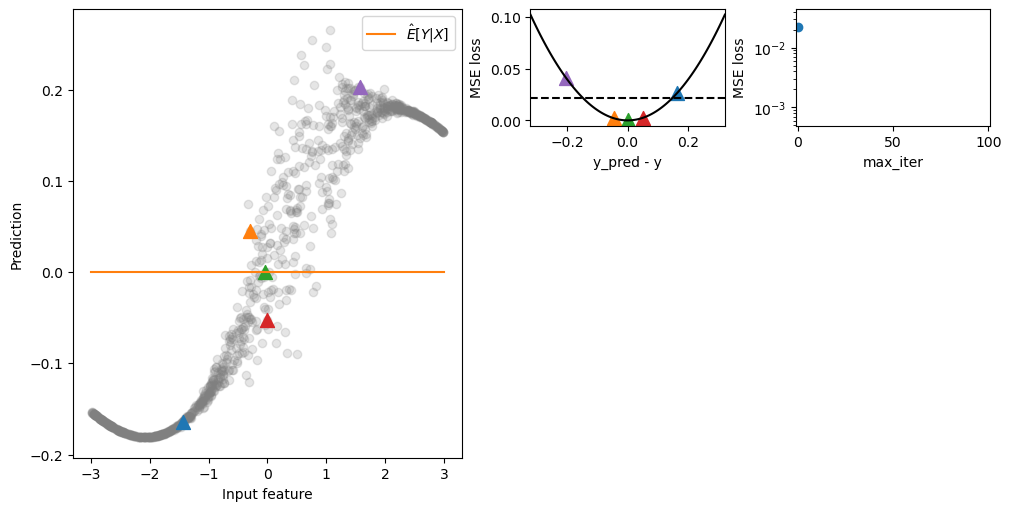

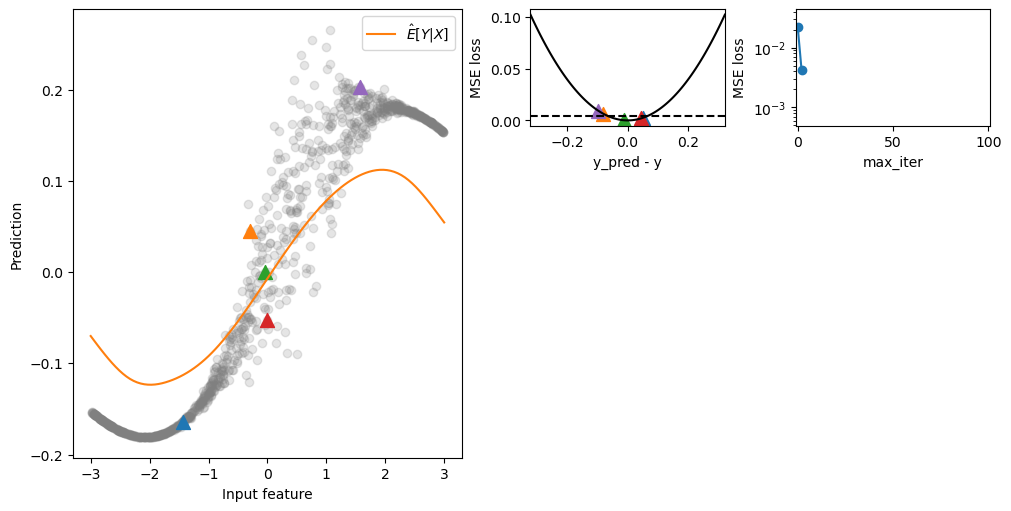

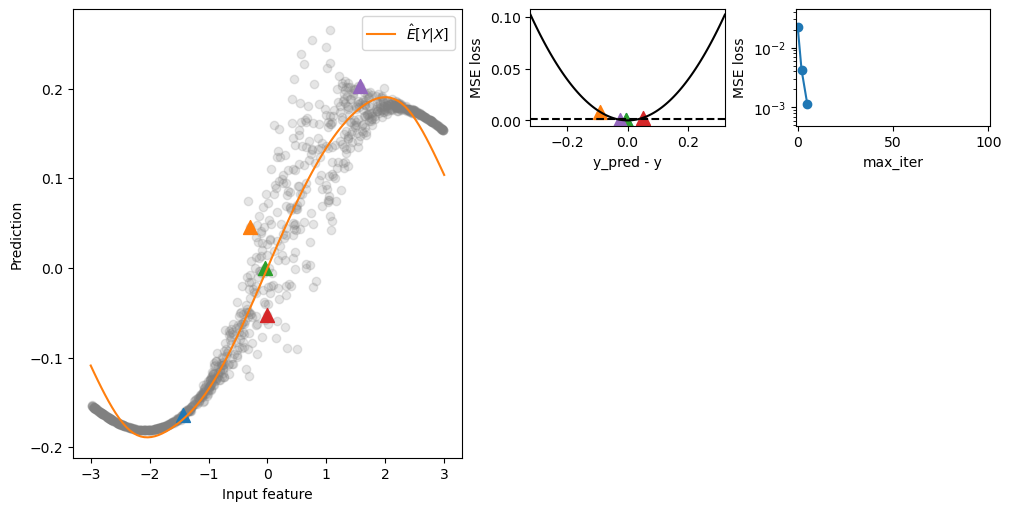

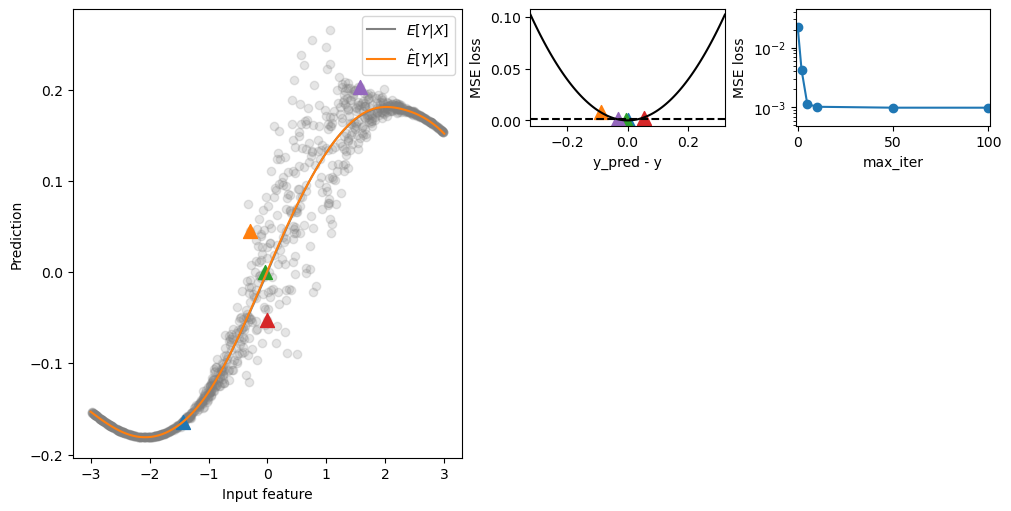

In [11]:
def loss_from_model(model):
    if hasattr(model, "steps"):
        model = model.steps[-1][1]
    return make_loss_function(model.loss, quantile=model.quantile)


def plot_model_triplet(models, x, ax=None, color="C1", show_quantiles=True):
    x_grid = np.linspace(x.min(), x.max(), 100)
    X_grid = x_grid.reshape((x_grid.shape[0], 1))
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)

    ax.plot(x_grid, models[0].predict(X_grid), label=r"$\hat{E}[Y|X]$", color=color)
    if show_quantiles:
        ax.plot(
            x_grid,
            models[1].predict(X_grid),
            linestyle="--",
            color=color,
        )
        ax.plot(
            x_grid,
            models[2].predict(X_grid),
            linestyle="--",
            label=r"$\hat{Q}[Y|X]$",
            color=color,
        )
    ax.set(
        xlabel="Input feature",
        ylabel="Prediction",
    )
    ax.legend()


def plot_loss_curve(max_iters, models, X, y, display_step, ax=None):
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)
    loss_fun, loss_label = loss_from_model(models[0])
    max_iters = np.asarray(max_iters)
    loss_values = np.asarray([loss_fun(y, m.predict(X)) for m in models])

    ax.plot(max_iters[: display_step + 1], loss_values[: display_step + 1], marker="o")
    ax.set(
        xlabel="max_iter",
        ylabel=loss_label,
        yscale="log",
        xlim=(max_iters.min() - 1, max_iters.max() + 1),
        ylim=(loss_values.min() * 0.5, loss_values.max() * 2),
    )


def plot_curves(record, model_name, show_quantiles=True):
    for display_step in [0, 1, 2, len(record) - 1]:

        truncated_record = record[: display_step + 1]
        fig = plt.figure(figsize=(10, 5), layout="constrained")
        ax0 = plt.subplot2grid((3, 4), (0, 0), rowspan=3, colspan=2)
        ax1 = plt.subplot2grid((3, 4), (0, 2))
        if show_quantiles:
            ax2 = plt.subplot2grid((3, 4), (1, 2))
            ax3 = plt.subplot2grid((3, 4), (2, 2))
        else:
            ax2, ax3 = None, None

        ax4 = plt.subplot2grid((3, 4), (0, 3))
        if show_quantiles:
            ax5 = plt.subplot2grid((3, 4), (1, 3))
            ax6 = plt.subplot2grid((3, 4), (2, 3))
        else:
            ax5, ax6 = None, None

        is_last_in_record = display_step == len(record) - 1
        plot_data_generating_process(
            x_train,
            y_train,
            highlight_indices=highlight_indices,
            plot_mean=is_last_in_record,
            plot_005_quantile=show_quantiles and is_last_in_record,
            plot_095_quantile=show_quantiles and is_last_in_record,
            ax=ax0,
        )
        plot_model_triplet(
            truncated_record[-1]["model_triplet"],
            x_train,
            show_quantiles=show_quantiles,
            ax=ax0,
        )
        for model_idx, (ax_loss_fun, ax_loss_curve) in enumerate(
            [(ax1, ax4), (ax2, ax5), (ax3, ax6)],
        ):
            last_model = truncated_record[-1]["model_triplet"][model_idx]
            loss_fun, loss_label = loss_from_model(last_model)
            if loss_fun is not mean_squared_error and not show_quantiles:
                continue

            plot_loss_function(
                loss_fun,
                loss_label,
                y_train,
                last_model.predict(X_train),
                highlight_indices=highlight_indices,
                legend=False,
                ax=ax_loss_fun,
            )

            plot_loss_curve(
                [r["max_iter"] for r in poly_reg_record],
                [r["model_triplet"][model_idx] for r in poly_reg_record],
                X_train,
                y_train,
                display_step,
                ax=ax_loss_curve,
            )
        if show_quantiles:
            with_or_without = "with"
        else:
            with_or_without = "without"
        fig.savefig(
            f"probabilistic_regression_curves_step"
            f"_{model_name.lower().replace(" ", "_")}"
            f"_{with_or_without}_quantiles"
            f"_{display_step:02d}.png"
        )


plot_curves(poly_reg_record, "Polynomial Regressor", show_quantiles=False)

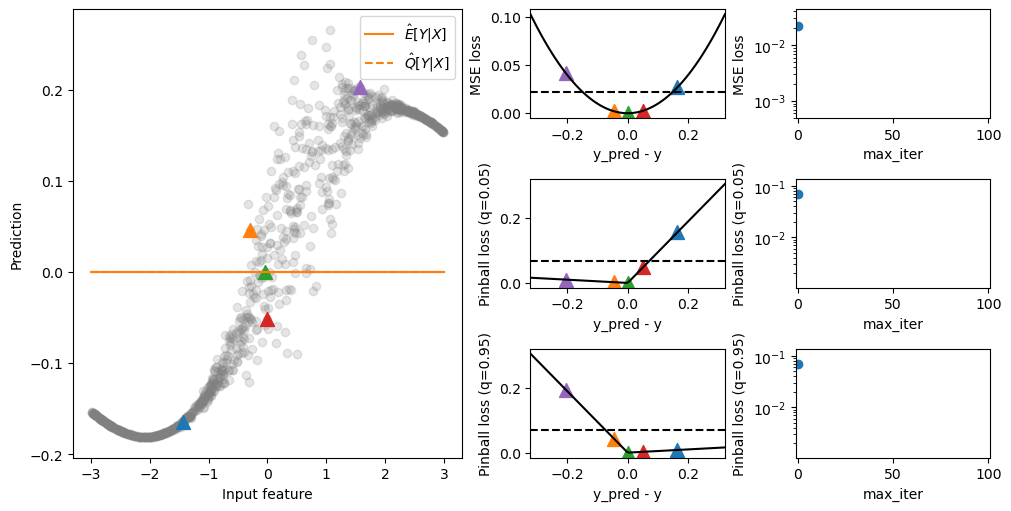

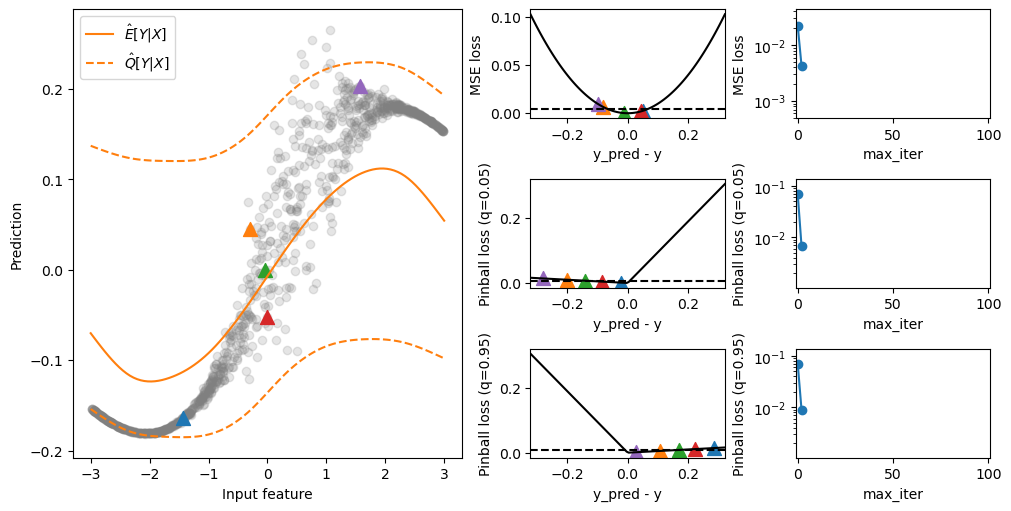

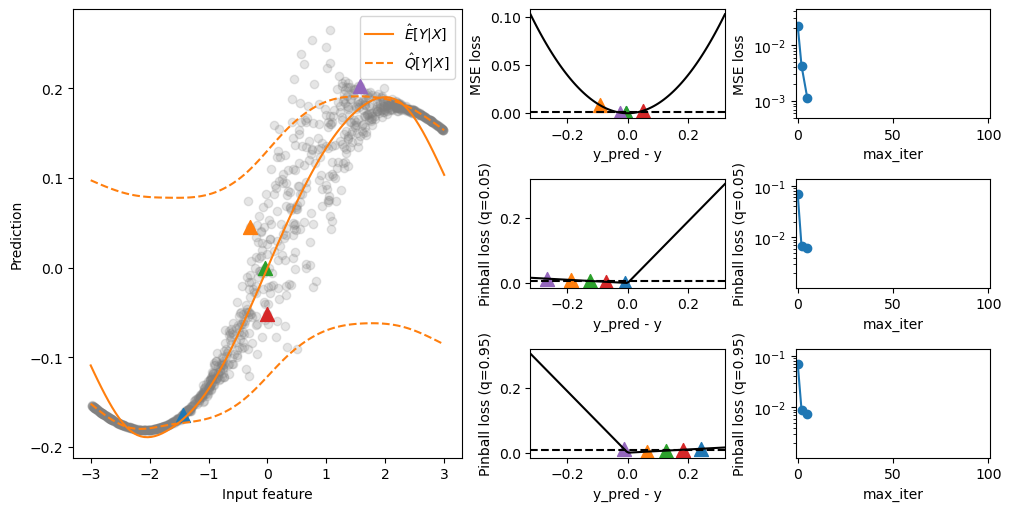

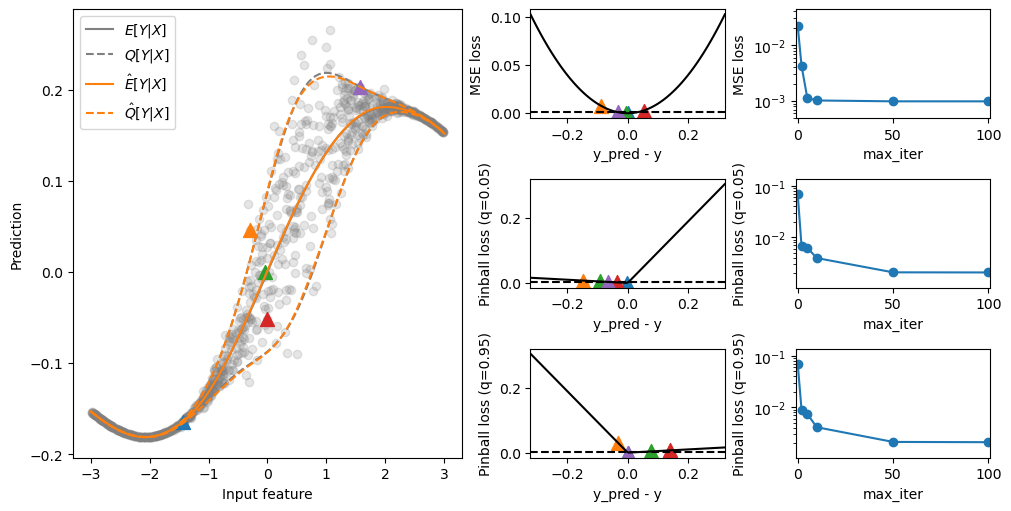

In [12]:
plot_curves(poly_reg_record, "Polynomial Regressor", show_quantiles=True)

In [13]:
class QuantilePairEvaluator:

    def __init__(self, y, data_name, quantile_levels=(0.05, 0.95)):
        self.quantile_level_low, self.quantile_level_high = quantile_levels
        self.data_name = data_name
        self.y = y
        self.records = []

    def evaluate(self, model_name, q_pred_low, q_pred_high):
        pb_loss_low = mean_pinball_loss(
            self.y, q_pred_low, alpha=self.quantile_level_low
        )
        pb_loss_high = mean_pinball_loss(
            self.y, q_pred_low, alpha=self.quantile_level_high
        )
        coverage = np.logical_and(
            self.y >= q_pred_low,
            self.y <= q_pred_high,
        ).mean()
        mean_width = np.abs(q_pred_high - q_pred_low).mean()
        self.records.append(
            {
                "model": model_name,
                f"pinball q={self.quantile_level_low:.2f}": pb_loss_low,
                f"pinball q={self.quantile_level_high:.2f}": pb_loss_high,
                "coverage": coverage,
                "interval width": mean_width,
            }
        )

    def to_frame(self, rounding_digits=4):
        return pd.DataFrame(self.records).round(rounding_digits)


poly_qreg_below, poly_qreg_above = poly_reg_record[-1]["model_triplet"][1:3]

quantile_evaluator_test = QuantilePairEvaluator(y_test, "test")
quantile_evaluator_test.evaluate(
    "Polynomial QReg", poly_qreg_below.predict(X_test), poly_qreg_above.predict(X_test)
)
quantile_evaluator_test.to_frame()

,model,pinball q=0.05,pinball q=0.95,coverage,interval width
0,Polynomial QReg,0.002,0.0314,0.8988,0.0648


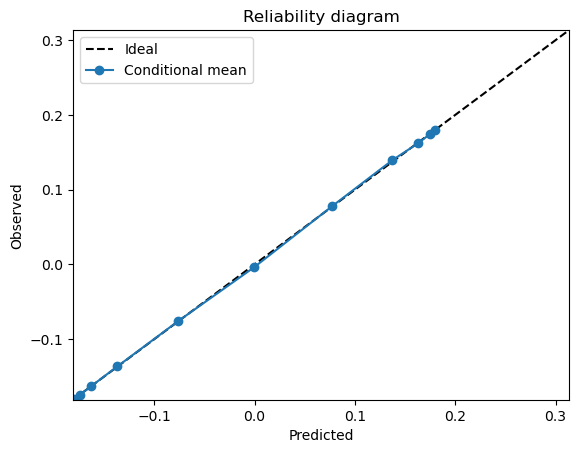

In [14]:
fig, ax = plt.subplots()
reliability_diagram(
    pd.DataFrame(dict(y=y_test, y_pred=poly_reg_triplet[0].predict(X_test))), ax=ax
)

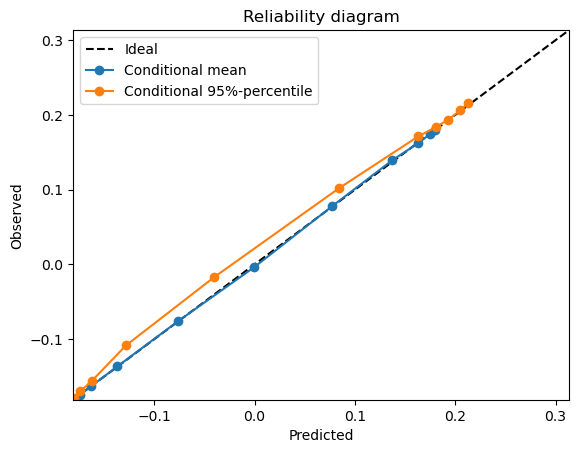

In [15]:
fig, ax = plt.subplots()
reliability_diagram(
    pd.DataFrame(dict(y=y_test, y_pred=poly_reg_triplet[0].predict(X_test))), ax=ax
)
reliability_diagram(
    pd.DataFrame(dict(y=y_test, y_pred=poly_reg_triplet[2].predict(X_test))),
    quantile_level=0.95,
    show_ideal=False,
    ax=ax,
)

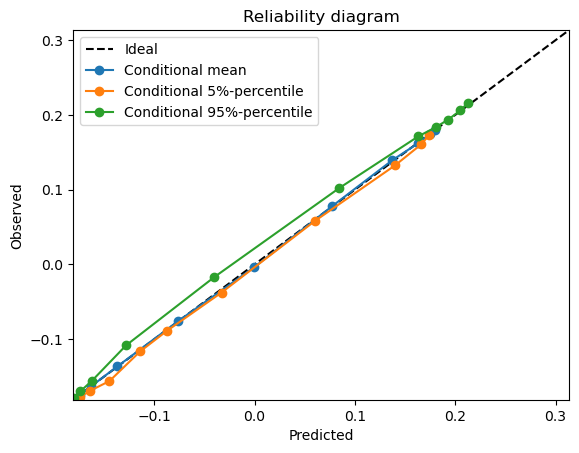

In [16]:
fig, ax = plt.subplots()
reliability_diagram(
    pd.DataFrame(dict(y=y_test, y_pred=poly_reg_triplet[0].predict(X_test))), ax=ax
)
reliability_diagram(
    pd.DataFrame(dict(y=y_test, y_pred=poly_reg_triplet[1].predict(X_test))),
    quantile_level=0.05,
    show_ideal=False,
    ax=ax,
)
reliability_diagram(
    pd.DataFrame(dict(y=y_test, y_pred=poly_reg_triplet[2].predict(X_test))),
    quantile_level=0.95,
    show_ideal=False,
    ax=ax,
)

In [17]:
from sklearn.ensemble import HistGradientBoostingRegressor
from threadpoolctl import threadpool_limits

shared_params = dict(max_leaf_nodes=5)
hgbt_reg_record = []
hgbt_reg_max_iters = [1, 5, 10, 50, 100]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    with threadpool_limits(limits=1):
        for max_iter in hgbt_reg_max_iters:
            shared_params["max_iter"] = max_iter
            model_triplet = (
                HistGradientBoostingRegressor(**shared_params).fit(X_train, y_train),
                HistGradientBoostingRegressor(
                    loss="quantile", quantile=0.05, **shared_params
                ).fit(X_train, y_train),
                HistGradientBoostingRegressor(
                    loss="quantile", quantile=0.95, **shared_params
                ).fit(X_train, y_train),
            )
            print(tuple(int(e.n_iter_) for e in model_triplet))
            hgbt_reg_record.append(
                dict(
                    max_iter=max_iter,
                    model_triplet=model_triplet,
                )
            )

(1, 1, 1)
(5, 5, 5)
(10, 10, 10)
(50, 50, 50)
(100, 100, 100)


In [18]:
model_triplet[2]

,"loss loss: {'squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile'}, default='squared_error'The loss function to use in the boosting process. Note that the""squared error"", ""gamma"" and ""poisson"" losses actually implement""half least squares loss"", ""half gamma deviance"" and ""half poissondeviance"" to simplify the computation of the gradient. Furthermore,""gamma"" and ""poisson"" losses internally use a log-link, ""gamma""requires ``y > 0`` and ""poisson"" requires ``y >= 0``.""quantile"" uses the pinball loss... versionchanged:: 0.23 Added option 'poisson'... versionchanged:: 1.1 Added option 'quantile'... versionchanged:: 1.3 Added option 'gamma'.",'quantile'
,"quantile quantile: float, default=NoneIf loss is ""quantile"", this parameter specifies which quantile to be estimatedand must be between 0 and 1.",0.95
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.1
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees.",100
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",5
,"max_depth max_depth: int or None, default=NoneThe maximum depth of each tree. The depth of a tree is the number ofedges to go from the root to the deepest leaf.Depth isn't constrained by default.",None
,"min_samples_leaf min_samples_leaf: int, default=20The minimum number of samples per leaf. For small datasets with lessthan a few hundred samples, it is recommended to lower this valuesince only very shallow trees would be built.",20
,"l2_regularization l2_regularization: float, default=0The L2 regularization parameter penalizing leaves with small hessians.Use ``0`` for no regularization (default).",0.0
,"max_features max_features: float, default=1.0Proportion of randomly chosen features in each and every node split.This is a form of regularization, smaller values make the trees weakerlearners and might prevent overfitting.If interaction constraints from `interaction_cst` are present, only allowedfeatures are taken into account for the subsampling... versionadded:: 1.4",1.0
,"max_bins max_bins: int, default=255The maximum number of bins to use for non-missing values. Beforetraining, each feature of the input array `X` is binned intointeger-valued bins, which allows for a much faster training stage.Features with a small number of unique values may use less than``max_bins`` bins. In addition to the ``max_bins`` bins, one more binis always reserved for missing values. Must be no larger than 255.",255
,"categorical_features categorical_features: array-like of {bool, int, str} of shape (n_features) or shape (n_categorical_features,), default='from_dtype'Indicates the categorical features.- None : no feature will be considered categorical.- boolean array-like : boolean mask indicating categorical features.- integer array-like : integer indices indicating categorical features.- str array-like: names of categorical features (assuming the training data has feature names).- `""from_dtype""`: dataframe columns with dtype ""category"" are considered to be categorical features. The input must be an object exposing a ``__dataframe__`` method such as pandas or polars DataFrames to use this feature.For each categorical feature, there must be at most `max_bins` uniquecategories. Negative values for categorical features encoded as numericdtypes are treated as missing values. All categorical values areconverted to floating point numbers. This means that categorical valuesof 1.0 and 1 are treated as the same category.Read more in the :ref:`User Guide ` and:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_categorical.py`... versionadded:: 0.24.. versionchanged:: 1.2 Added support for feature names... versionchanged:: 1.4 Ad

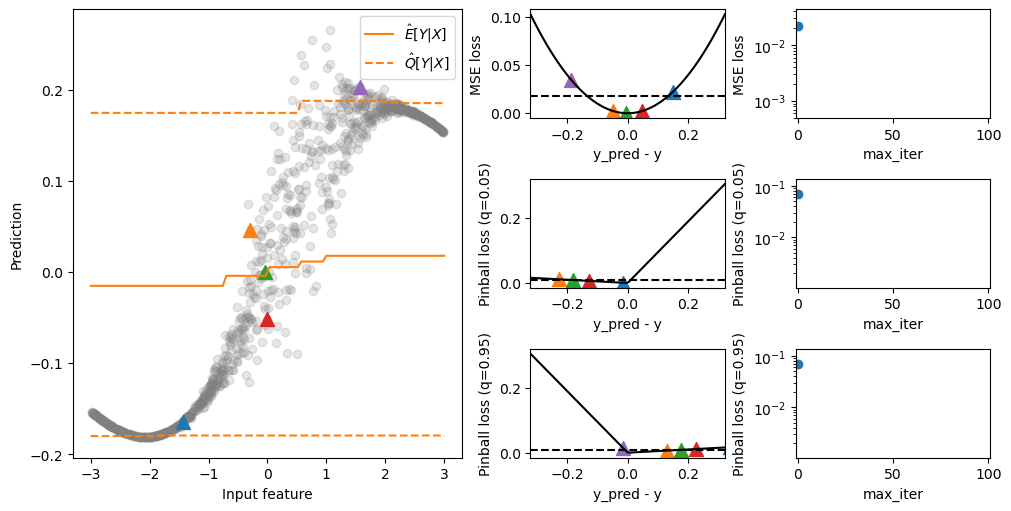

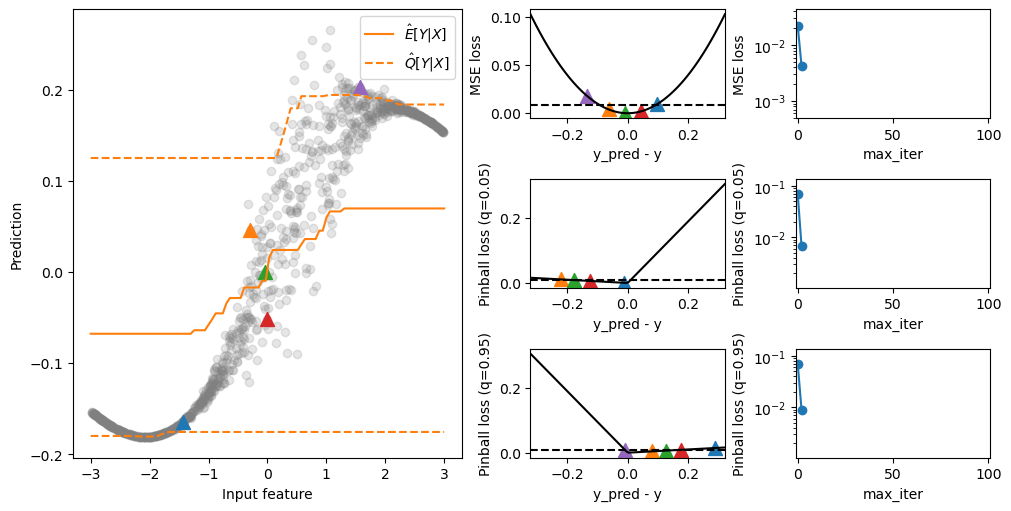

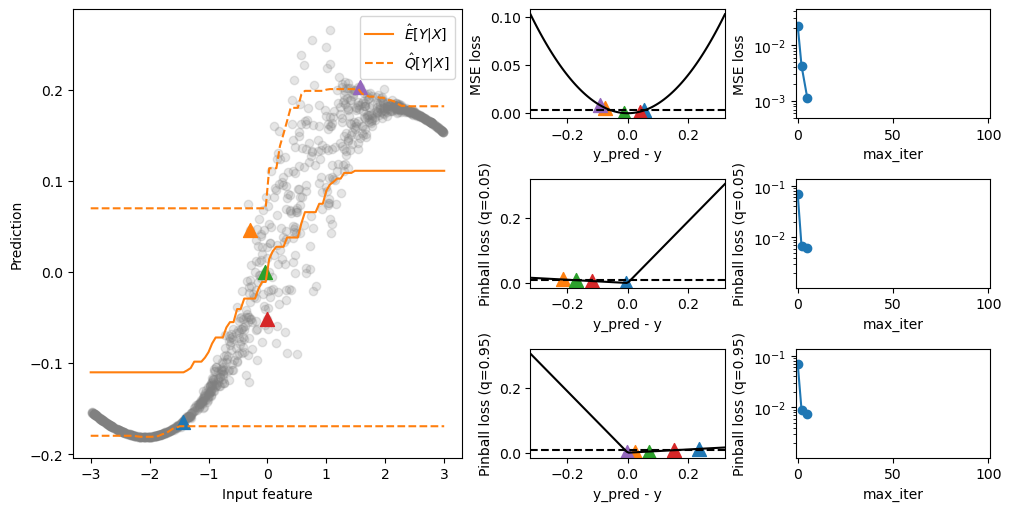

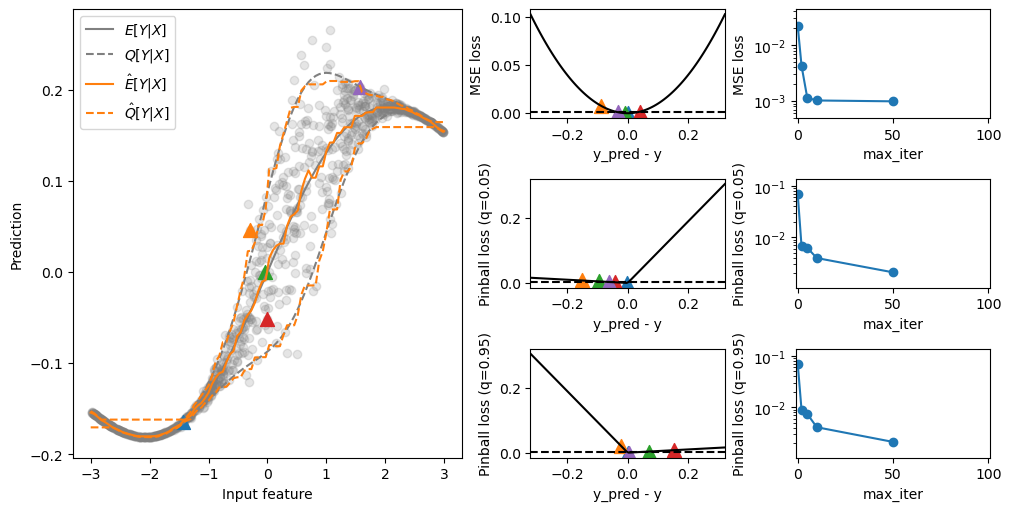

In [19]:
plot_curves(hgbt_reg_record, "HGBDT")

In [20]:
hgbt_qreg_below, hgbt_qreg_above = hgbt_reg_record[-1]["model_triplet"][1:3]

quantile_evaluator_test.evaluate(
    "HGBT QReg", hgbt_qreg_below.predict(X_test), hgbt_qreg_above.predict(X_test)
)
quantile_evaluator_test.to_frame()

,model,pinball q=0.05,pinball q=0.95,coverage,interval width
0,Polynomial QReg,0.0020,0.0314,0.8988,0.0648
1,HGBT QReg,0.0022,0.0344,0.9187,0.0710


In [21]:
from scipy.interpolate import interp1d
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils.validation import check_consistent_length
from sklearn.linear_model import LogisticRegression


class BinnedQuantileRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimator=None, n_bins=30, random_state=None):
        self.estimator = estimator
        self.n_bins = n_bins
        self.random_state = random_state

    def fit(self, X, y):
        # Lightweight input validation: most of the input validation will be
        # handled by the sub estimators.
        check_consistent_length(X, y)
        self.target_binner_ = KBinsDiscretizer(
            n_bins=self.n_bins,
            strategy="quantile",
            encode="ordinal",
            quantile_method="averaged_inverted_cdf",
        )

        y_binned = self.target_binner_.fit_transform(
            np.asarray(y).reshape(-1, 1)
        ).ravel()

        # Fit the multiclass classifier to predict the binned targets from the
        # training set.
        if self.estimator is None:
            estimator = LogisticRegression()
        else:
            estimator = clone(self.estimator)
        self.estimator_ = estimator.fit(X, y_binned)
        return self

    def predict_quantiles(self, X, quantiles):
        check_is_fitted(self, "estimator_")
        thresholds = self.target_binner_.bin_edges_[0]
        y_proba = self.estimator_.predict_proba(X)
        y_cdf = np.zeros(shape=(X.shape[0], thresholds.shape[0]))
        y_cdf[:, 1:] = np.cumsum(y_proba, axis=1)

        # Build the mapper for inverse CDF mapping, from cumulated
        # probabilities to continuous prediction.
        return np.asarray(
            [interp1d(y_cdf_i, thresholds)(quantiles) for y_cdf_i in y_cdf]
        )


base_classifier = make_pipeline(
    SplineTransformer(n_knots=10),
    LogisticRegression(C=1000, max_iter=1000),
)
bqr = BinnedQuantileRegressor(base_classifier, n_bins=1_000, random_state=0).fit(
    X_train, y_train
)
bqr

,estimator,Pipeline(step..._iter=1000))])
,n_bins,1000
,random_state,0
,"n_knots n_knots: int, default=5Number of knots of the splines if `knots` equals one of{'uniform', 'quantile'}. Must be larger or equal 2. Ignored if `knots`is array-like.",10
,"degree degree: int, default=3The polynomial degree of the spline basis. Must be a non-negativeinteger.",3
,"knots knots: {'uniform', 'quantile'} or array-like of shape (n_knots, n_features), default='uniform'Set knot positions such that first knot <= features <= last knot.- If 'uniform', `n_knots` number of knots are distributed uniformly from min to max values of the features.- If 'quantile', they are distributed uniformly along the quantiles of the features.- If an array-like is given, it directly specifies the sorted knot positions including the boundary knots. Note that, internally, `degree` number of knots are added before the first knot, the same after the last knot.",'uniform'
,"extrapolation extrapolation: {'error', 'constant', 'linear', 'continue', 'periodic'}, default='constant'If 'error', values outside the min and max values of the trainingfeatures raises a `ValueError`. If 'constant', the value of thesplines at minimum and maximum value of the features is used asconstant extrapolation. If 'linear', a linear extrapolation is used.If 'continue', the splines are extrapolated as is, i.e. option`extrapolate=True` in :class:`scipy.interpolate.BSpline`. If'periodic', periodic splines with a periodicity equal to the distancebetween the first and last knot are used. Periodic splines enforceequal function values and derivatives at the first and last knot.For example, this makes it possible to avoid introducing an arbitraryjump between Dec 31st and Jan 1st in spline features derived from anaturally periodic ""day-of-year"" input feature. In this case it isrecommended to manually set the knot values to control the period.",'constant'
,"include_bias include_bias: bool, default=TrueIf False, then the last spline element inside the data rangeof a feature is dropped. As B-splines sum to one over the spline basisfunctions for each data point, they implicitly include a bias term,i.e. a column of ones. It acts as an intercept term in a linear models.",True
,"order order: {'C', 'F'}, default='C'Order of output array in the dense case. `'F'` order is faster to compute, butmay slow down subsequent estimators.",'C'
,"handle_missing handle_missing: {'error', 'zeros'}, default='error'Specifies the way missing values are handled.- 'error' : Raise an error if `np.nan` values are present during :meth:`fit`.- 'zeros' : Encode splines of missing values with values `0`.Note that `handle_missing='zeros'` differs from first imputing missing valueswith zeros and then creating the spline basis. The latter creates spline basisfunctions which have non-zero values at the missing valueswhereas this option simply sets all spline basis function values to zero at themissing values... versionadded:: 1.8",'error'
,"sparse_output sparse_output: bool, default=FalseWill return sparse CSR matrix if set True else will return an array... versionadded:: 1.2",False


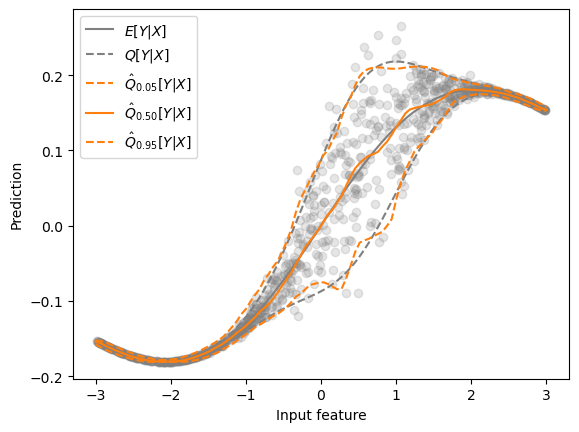

In [22]:
def plot_binned_qr(model, x, ax=None, color="C1"):
    x_grid = np.linspace(x.min(), x.max(), 100)
    X_grid = x_grid.reshape((x_grid.shape[0], 1))
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)

    quantile_levels = (0.05, 0.5, 0.95)
    q_pred = model.predict_quantiles(X_grid, quantile_levels)

    ax.plot(
        x_grid,
        q_pred[:, 0],
        label=r"$\hat{Q}_{0.05}[Y|X]$",
        color=color,
        linestyle="--",
    )
    ax.plot(x_grid, q_pred[:, 1], label=r"$\hat{Q}_{0.50}[Y|X]$", color=color)
    ax.plot(
        x_grid,
        q_pred[:, 2],
        label=r"$\hat{Q}_{0.95}[Y|X]$",
        color=color,
        linestyle="--",
    )
    ax.set(
        xlabel="Input feature",
        ylabel="Prediction",
    )
    ax.legend()


fig, ax = plt.subplots()
plot_data_generating_process(x_train, y_train, ax=ax)
plot_binned_qr(bqr, x, ax=ax)

In [23]:
binned_q_pred =  bqr.predict_quantiles(X_test, quantiles=[0.05, 0.95])
quantile_evaluator_test.evaluate(
    "Polynomial QReg via target binning", binned_q_pred[:, 0], binned_q_pred[:, 1]
)
quantile_evaluator_test.to_frame()

,model,pinball q=0.05,pinball q=0.95,coverage,interval width
0,Polynomial QReg,0.0020,0.0314,0.8988,0.0648
1,HGBT QReg,0.0022,0.0344,0.9187,0.0710
2,Polynomial QReg via target binning,0.0022,0.0325,0.9358,0.0691


In [24]:
from sklearn.linear_model import BayesianRidge


poly_br = make_pipeline(SplineTransformer(n_knots=10), BayesianRidge()).fit(
    X_train, y_train
)
poly_br

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('splinetransformer', ...), ('bayesianridge', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_knots n_knots: int, default=5Number of knots of the splines if `knots` equals one of{'uniform', 'quantile'}. Must be larger or equal 2. Ignored if `knots`is array-like.",10
,"degree degree: int, default=3The polynomial degree of the spline basis. Must be a non-negativeinteger.",3
,"knots knots: {'uniform', 'quantile'} or array-like of shape (n_knots, n_features), default='uniform'Set knot positions such that first knot <= features <= last knot.- If 'uniform', `n_knots` number of knots are distributed uniformly from min to max values of the features.- If 'quantile', they are distributed uniformly along the quantiles of the features.- If an array-like is given, it directly specifies the sorted knot positions including the boundary knots. Note that, internally, `degree` number of knots are added before the first knot, the same after the last knot.",'uniform'
,"extrapolation extrapolation: {'error', 'constant', 'linear', 'continue', 'periodic'}, default='constant'If 'error', values outside the min and max values of the trainingfeatures raises a `ValueError`. If 'constant', the value of thesplines at minimum and maximum value of the features is used asconstant extrapolation. If 'linear', a linear extrapolation is used.If 'continue', the splines are extrapolated as is, i.e. option`extrapolate=True` in :class:`scipy.interpolate.BSpline`. If'periodic', periodic splines with a periodicity equal to the distancebetween the first and last knot are used. Periodic splines enforceequal function values and derivatives at the first and last knot.For example, this makes it possible to avoid introducing an arbitraryjump between Dec 31st and Jan 1st in spline features derived from anaturally periodic ""day-of-year"" input feature. In this case it isrecommended to manually set the knot values to control the period.",'constant'
,"include_bias include_bias: bool, default=TrueIf False, then the last spline element inside the data rangeof a feature is dropped. As B-splines sum to one over the spline basisfunctions for each data point, they implicitly include a bias term,i.e. a column of ones. It acts as an intercept term in a linear models."

In [25]:

def mean_quantiles_from_mean_std(model, X, quantile_levels=(0.05, 0.95)):
    mean_pred, std_pred = model.predict(X, return_std=True)
    quantile_high_pred = mean_pred + norm.ppf(quantile_levels[1]) * std_pred
    quantile_low_pred = mean_pred - norm.ppf(1 - quantile_levels[0]) * std_pred
    return mean_pred, quantile_low_pred, quantile_high_pred


def plot_mean_std_predictions(
    model,
    x,
    plot_mean=True,
    plot_low_high=True,
    color="C1",
    quantile_levels=(0.05, 0.95),
    ax=None,
):
    x_grid = np.linspace(x.min(), x.max(), 100)
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)

    mean_pred, quantile_low_pred, quantile_high_pred = mean_quantiles_from_mean_std(
        model, x_grid.reshape(-1, 1), quantile_levels=quantile_levels
    )
    if plot_mean:
        ax.plot(x_grid, mean_pred, label=r"$\hat{E}[Y|X]$", color=color)

    if plot_low_high:
        ax.plot(
            x_grid,
            quantile_low_pred,
            linestyle="--",
            color=color,
        )
        ax.plot(
            x_grid,
            quantile_high_pred,
            linestyle="--",
            label=r"$\hat{Q}[Y|X]$",
            color=color,
        )


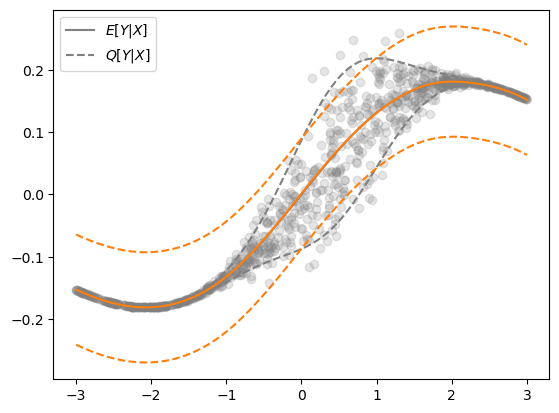

In [26]:
fig, ax = plt.subplots()
plot_data_generating_process(x, y, ax=ax)
plot_mean_std_predictions(poly_br, x_train, ax=ax)

In [27]:
_, poly_br_low, poly_br_high = mean_quantiles_from_mean_std(poly_br, X_test)

quantile_evaluator_test.evaluate("Polynomial Bayesian Ridge", poly_br_low, poly_br_high)
quantile_evaluator_test.to_frame()

,model,pinball q=0.05,pinball q=0.95,coverage,interval width
0,Polynomial QReg,0.0020,0.0314,0.8988,0.0648
1,HGBT QReg,0.0022,0.0344,0.9187,0.0710
2,Polynomial QReg via target binning,0.0022,0.0325,0.9358,0.0691
3,Polynomial Bayesian Ridge,0.0049,0.0843,0.9667,0.1767


In [28]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import ConstantKernel, Matern
# from sklearn.utils import resample

# kernel = ConstantKernel(1.0, constant_value_bounds=(0.01, 10)) * Matern(
#     length_scale=1e-4,
#     length_scale_bounds=(1e-5, 1e2)
# )
# gpr = make_pipeline(
#     # SplineTransformer(),
#     GaussianProcessRegressor(kernel=kernel),
# ).fit(*resample(X_train, y_train, n_samples=2000))

# fig, ax = plt.subplots()
# plot_data_generating_process(x, y, ax=ax)
# plot_mean_std_predictions(gpr, x_train, ax=ax)

In [29]:
from mapie.regression import CrossConformalRegressor


poly_ccr = CrossConformalRegressor(
    make_pipeline(SplineTransformer(n_knots=n_knots), LinearRegressor(alpha=1e-6)),
    confidence_level=0.9,
).fit_conformalize(X_train, y_train)

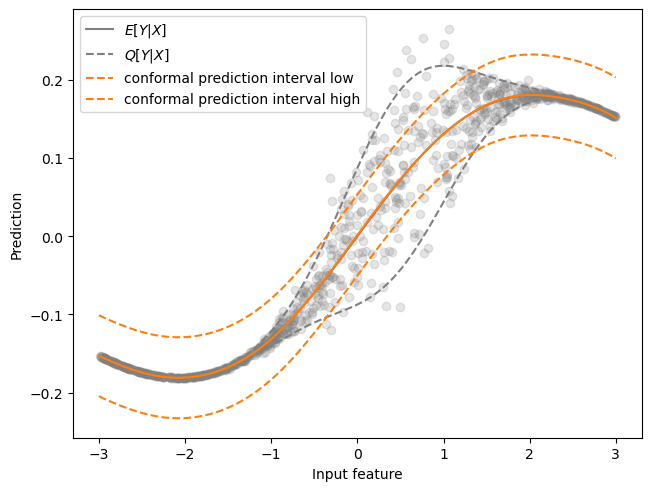

In [30]:
def plot_conformal_predictions(model, x, color="C1", ax=None):
    x_grid = np.linspace(x.min(), x.max(), 100)
    X_grid = x_grid.reshape((x_grid.shape[0], 1))
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)

    mean_pred, interval_pred = model.predict_interval(X_grid)
    interval_pred = interval_pred.squeeze()

    ax.plot(
        x_grid,
        interval_pred[:, 0],
        color=color,
        label="conformal prediction interval low",
        linestyle="--",
    )
    ax.plot(x_grid, mean_pred, color=color)
    ax.plot(
        x_grid,
        interval_pred[:, 1],
        color=color,
        label="conformal prediction interval high",
        linestyle="--",
    )
    ax.set(
        xlabel="Input feature",
        ylabel="Prediction",
    )
    ax.legend()

fig, ax = plt.subplots(constrained_layout=True)
plot_data_generating_process(X_train, y_train, ax=ax)
plot_conformal_predictions(poly_ccr, x_train, ax=ax)

In [31]:
_, poly_ccr_pred = poly_ccr.predict_interval(X_test)
poly_ccr_pred = poly_ccr_pred.squeeze()

quantile_evaluator_test.evaluate(
    "Cross-conformalized Polynomial Ridge", poly_ccr_pred[:, 0], poly_ccr_pred[:, 1]
)
quantile_evaluator_test.to_frame()

,model,pinball q=0.05,pinball q=0.95,coverage,interval width
0,Polynomial QReg,0.0020,0.0314,0.8988,0.0648
1,HGBT QReg,0.0022,0.0344,0.9187,0.0710
2,Polynomial QReg via target binning,0.0022,0.0325,0.9358,0.0691
3,Polynomial Bayesian Ridge,0.0049,0.0843,0.9667,0.1767
4,Cross-conformalized Polynomial Ridge,0.0042,0.0507,0.8992,0.1036


In [32]:
from mapie.regression import ConformalizedQuantileRegressor


cqr_poly_reg = (
    ConformalizedQuantileRegressor(
        (poly_reg_triplet[1], poly_reg_triplet[2], poly_reg_triplet[0]),
        prefit=True,
    )
    .conformalize(X_cal, y_cal)
)

cqr_poly_reg_mid_pred, cqr_poly_reg_pred = cqr_poly_reg.predict_interval(X_test)
cqr_poly_reg_pred = cqr_poly_reg_pred.squeeze()
quantile_evaluator_test.evaluate(
    "CQR of Polynomial QReg", cqr_poly_reg_pred[:, 0], cqr_poly_reg_pred[:, 1]
)
quantile_evaluator_test.to_frame()

INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.


,model,pinball q=0.05,pinball q=0.95,coverage,interval width
0,Polynomial QReg,0.0020,0.0314,0.8988,0.0648
1,HGBT QReg,0.0022,0.0344,0.9187,0.0710
2,Polynomial QReg via target binning,0.0022,0.0325,0.9358,0.0691
3,Polynomial Bayesian Ridge,0.0049,0.0843,0.9667,0.1767
4,Cross-conformalized Polynomial Ridge,0.0042,0.0507,0.8992,0.1036
5,CQR of Polynomial QReg,0.0020,0.0314,0.8888,0.0648


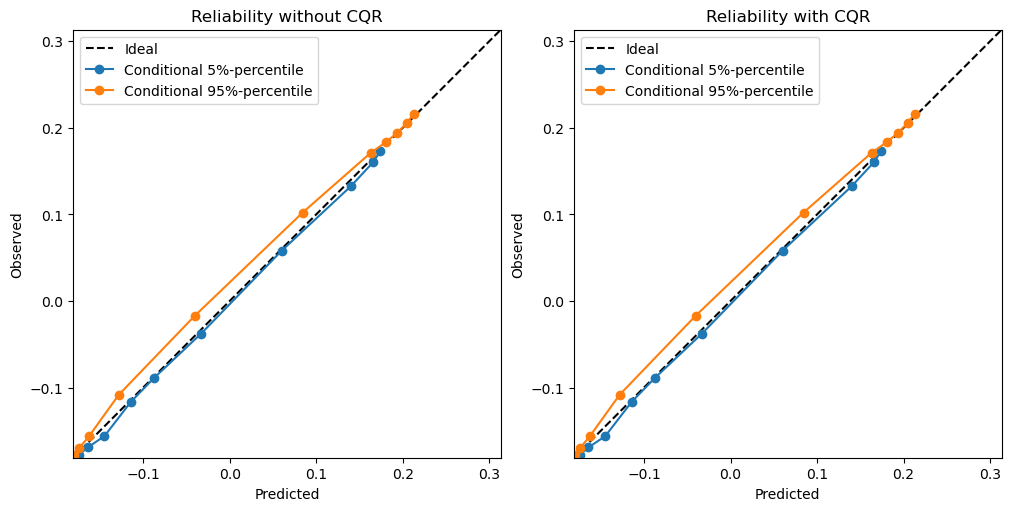

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), constrained_layout=True)
reliability_diagram(
    pd.DataFrame(dict(y=y_test, y_pred=poly_reg_triplet[1].predict(X_test))),
    quantile_level=0.05,
    ax=ax[0],
)
reliability_diagram(
    pd.DataFrame(dict(y=y_test, y_pred=poly_reg_triplet[2].predict(X_test))),
    quantile_level=0.95,
    show_ideal=False,
    ax=ax[0],
)
ax[0].set_title("Reliability without CQR")
reliability_diagram(
    pd.DataFrame(dict(y=y_test, y_pred=cqr_poly_reg_pred[:, 0])),
    quantile_level=0.05,
    ax=ax[1],
)
reliability_diagram(
    pd.DataFrame(dict(y=y_test, y_pred=cqr_poly_reg_pred[:, 1])),
    quantile_level=0.95,
    show_ideal=False,
    ax=ax[1],
)
_ = ax[1].set_title("Reliability with CQR")

INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.


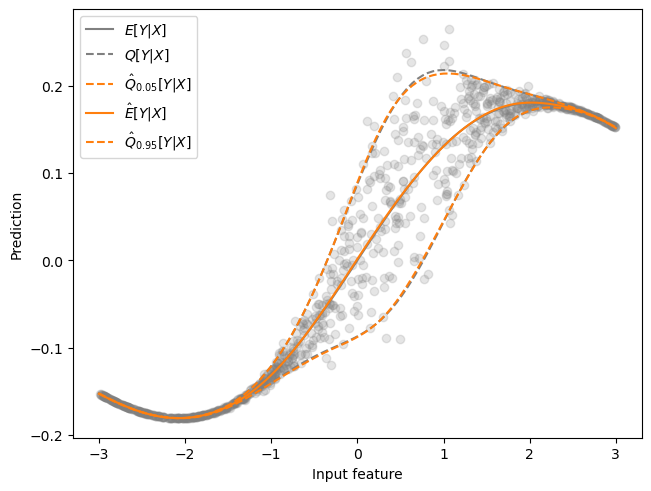

In [34]:
def plot_quantile_predictions(
    X_grid, mid_pred, q_pred_low, q_pred_high, color="C1", ax=None
):
    x_grid = X_grid.ravel()
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)

    ax.plot(
        x_grid,
        q_pred_low,
        label=r"$\hat{Q}_{0.05}[Y|X]$",
        color=color,
        linestyle="--",
    )
    ax.plot(x_grid, mid_pred, label=r"$\hat{E}[Y|X]$", color=color)
    ax.plot(
        x_grid,
        q_pred_high,
        label=r"$\hat{Q}_{0.95}[Y|X]$",
        color=color,
        linestyle="--",
    )
    ax.set(
        xlabel="Input feature",
        ylabel="Prediction",
    )
    ax.legend()


fig, ax = plt.subplots(constrained_layout=True)
plot_data_generating_process(X_train, y_train, ax=ax)

X_train_grid = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)
cqr_poly_reg_mid_pred, cqr_poly_reg_pred = cqr_poly_reg.predict_interval(X_train_grid)
cqr_poly_reg_pred = cqr_poly_reg_pred.squeeze()
plot_quantile_predictions(
    X_train_grid,
    cqr_poly_reg_mid_pred,
    cqr_poly_reg_pred[:, 0],
    cqr_poly_reg_pred[:, 1],
    ax=ax,
)

In [35]:
bad_shared_params = dict(
    alpha=5e-3,
    l1_ratio=0.5,
)

bad_poly_reg_triplet = (
    make_pipeline(
        SplineTransformer(n_knots=n_knots), LinearRegressor(**bad_shared_params)
    ).fit(X_train, y_train),
    make_pipeline(
        SplineTransformer(n_knots=n_knots),
        LinearRegressor(loss="quantile", quantile=0.05, **bad_shared_params),
    ).fit(X_train, y_train),
    make_pipeline(
        SplineTransformer(n_knots=n_knots),
        LinearRegressor(loss="quantile", quantile=0.95, **bad_shared_params),
    ).fit(X_train, y_train),
)

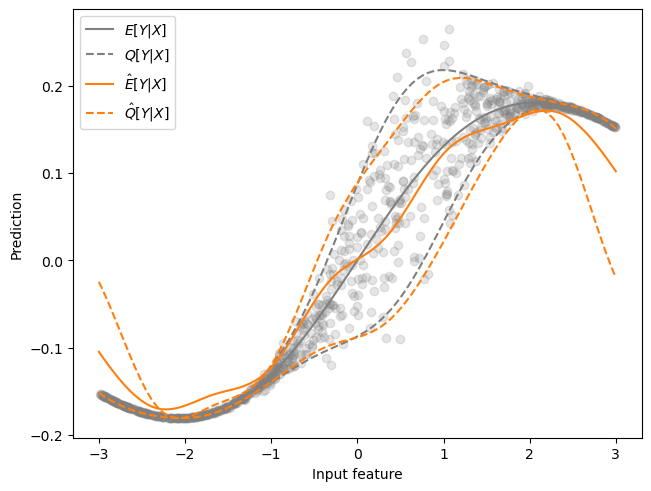

In [36]:
fig, ax = plt.subplots(constrained_layout=True)
plot_data_generating_process(X_train, y_train, ax=ax)
plot_model_triplet(bad_poly_reg_triplet, x_train, ax=ax)

In [37]:
quantile_evaluator_test.evaluate(
    "Bad Polynomial QReg",
    bad_poly_reg_triplet[1].predict(X_test),
    bad_poly_reg_triplet[2].predict(X_test),
)
quantile_evaluator_test.to_frame()

,model,pinball q=0.05,pinball q=0.95,coverage,interval width
0,Polynomial QReg,0.0020,0.0314,0.8988,0.0648
1,HGBT QReg,0.0022,0.0344,0.9187,0.0710
2,Polynomial QReg via target binning,0.0022,0.0325,0.9358,0.0691
3,Polynomial Bayesian Ridge,0.0049,0.0843,0.9667,0.1767
4,Cross-conformalized Polynomial Ridge,0.0042,0.0507,0.8992,0.1036
5,CQR of Polynomial QReg,0.0020,0.0314,0.8888,0.0648
6,Bad Polynomial QReg,0.0026,0.0452,0.8997,0.0865


In [38]:
cqr_bad_poly_reg = (
    ConformalizedQuantileRegressor(
        (bad_poly_reg_triplet[1], bad_poly_reg_triplet[2], bad_poly_reg_triplet[0]),
        prefit=True,
    )
    .conformalize(X_cal, y_cal)
)

cqr_bad_poly_reg_mid_pred, cqr_bad_poly_reg_pred = cqr_bad_poly_reg.predict_interval(X_test)
cqr_bad_poly_reg_pred = cqr_bad_poly_reg_pred.squeeze()
quantile_evaluator_test.evaluate(
    "CQR of Polynomial QReg", cqr_bad_poly_reg_pred[:, 0], cqr_bad_poly_reg_pred[:, 1]
)
quantile_evaluator_test.to_frame()

INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.


,model,pinball q=0.05,pinball q=0.95,coverage,interval width
0,Polynomial QReg,0.0020,0.0314,0.8988,0.0648
1,HGBT QReg,0.0022,0.0344,0.9187,0.0710
2,Polynomial QReg via target binning,0.0022,0.0325,0.9358,0.0691
3,Polynomial Bayesian Ridge,0.0049,0.0843,0.9667,0.1767
4,Cross-conformalized Polynomial Ridge,0.0042,0.0507,0.8992,0.1036
5,CQR of Polynomial QReg,0.0020,0.0314,0.8888,0.0648
6,Bad Polynomial QReg,0.0026,0.0452,0.8997,0.0865
7,CQR of Polynomial QReg,0.0026,0.0452,0.8983,0.0864


INFO:root:The predictions are ill-sorted.
INFO:root:The predictions are ill-sorted.


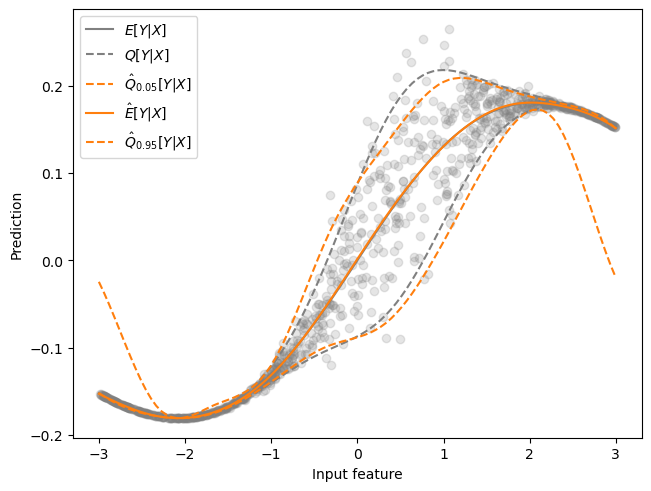

In [39]:
fig, ax = plt.subplots(constrained_layout=True)
plot_data_generating_process(X_train, y_train, ax=ax)
cqr_bad_poly_reg_mid_pred, cqr_bad_poly_reg_pred = cqr_bad_poly_reg.predict_interval(X_train_grid)
cqr_bad_poly_reg_pred = cqr_bad_poly_reg_pred.squeeze()
plot_quantile_predictions(
    X_train_grid,
    cqr_poly_reg_mid_pred,
    cqr_bad_poly_reg_pred[:, 0],
    cqr_bad_poly_reg_pred[:, 1],
    ax=ax,
)